# Sequence Aware Recommender System

## Import libraries

In [1]:
import sys, os, re
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# from jupyterthemes import jtplot
import copy as cp
import pickle as pkl

In [2]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from xgboost import XGBClassifier, plot_importance
# import lightgbm as lgb
# import catboost as cb
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.layers import LSTM
from keras.utils import to_categorical
# from keras.layers import Conv2D, MaxPool2D, BatchNormalization
# from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
plt.style.use('dark_background')
plt.axis('off')
plt.grid(b=None)
# set plot rc parameters
# jtplot.style(grid=False)
# plt.rcParams['figure.facecolor'] = '#464646'
# plt.rcParams['axes.facecolor'] = '#464646'
# plt.rcParams['savefig.facecolor'] = '#464646'
# plt.rcParams['axes.edgecolor'] = '#232323'
# plt.rcParams['figure.figsize'] = 10, 7
# plt.rcParams['axes.labelcolor'] = '#666666'
# plt.rcParams['xtick.color'] = '#666666'
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['axes.labelsize'] = 17
# plt.rcParams['ytick.color'] = '#666666'
# plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams['font.size'] = 16

sns.color_palette('dark')
%matplotlib inline

## Load Data

In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
train_dir = '/content/drive/My Drive/JantaHack Reccomendation systems/train'
test_dir = '/content/drive/My Drive/JantaHack Reccomendation systems/test'

In [7]:
train = pd.read_csv(train_dir+'/train.csv')
challenges = pd.read_csv(train_dir+'/challenge_data.csv')
test = pd.read_csv(test_dir+'/test.csv')

# shape of all the data
train.shape, test.shape, challenges.shape

((903916, 4), (397320, 4), (5606, 9))

## EDA

### Train data

In [8]:
train.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,1,CI23714
1,4576_2,4576,2,CI23855
2,4576_3,4576,3,CI24917
3,4576_4,4576,4,CI23663
4,4576_5,4576,5,CI23933


In [9]:
# info regarding variables in train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903916 entries, 0 to 903915
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       903916 non-null  object
 1   user_id             903916 non-null  int64 
 2   challenge_sequence  903916 non-null  int64 
 3   challenge           903916 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.6+ MB


In [10]:
# check for duplicates in train data
train.shape, train['user_sequence'].unique().shape

((903916, 4), (903916,))

In [11]:
train['user_id'].unique().shape, train['user_id'].value_counts().value_counts()

((69532,), 13    69532
 Name: user_id, dtype: int64)

In [12]:
train['challenge_sequence'].unique().shape, train['challenge_sequence'].value_counts()

((13,), 13    69532
 12    69532
 11    69532
 10    69532
 9     69532
 8     69532
 7     69532
 6     69532
 5     69532
 4     69532
 3     69532
 2     69532
 1     69532
 Name: challenge_sequence, dtype: int64)

In [13]:
train['challenge'].unique().shape

(5348,)

### Test data

In [14]:
test.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4577_1,4577,1,CI23855
1,4577_2,4577,2,CI23933
2,4577_3,4577,3,CI24917
3,4577_4,4577,4,CI24915
4,4577_5,4577,5,CI23714


In [15]:
# info regarding variables in train data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397320 entries, 0 to 397319
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       397320 non-null  object
 1   user_id             397320 non-null  int64 
 2   challenge_sequence  397320 non-null  int64 
 3   challenge           397320 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.1+ MB


In [16]:
# check for duplicates in train data
test.shape, test['user_sequence'].unique().shape

((397320, 4), (397320,))

In [17]:
test['user_id'].unique().shape, test['user_id'].value_counts().value_counts()

((39732,), 10    39732
 Name: user_id, dtype: int64)

In [18]:
test['challenge_sequence'].unique().shape, test['challenge_sequence'].value_counts()

((10,), 10    39732
 9     39732
 8     39732
 7     39732
 6     39732
 5     39732
 4     39732
 3     39732
 2     39732
 1     39732
 Name: challenge_sequence, dtype: int64)

In [19]:
test['challenge'].unique().shape

(4477,)

In [20]:
# check challenges present in test data but not in train data

challenges_not_in_train = set(test['challenge']).difference(set(train['challenge']))
len(challenges_not_in_train)

154

In [21]:
# check challenges present in train data but not in test data

challenges_not_in_test = set(train['challenge']).difference(set(test['challenge']))
len(challenges_not_in_test)

1025

### Challenges

In [22]:
challenges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   challenge_ID          5606 non-null   object 
 1   programming_language  5606 non-null   int64  
 2   challenge_series_ID   5594 non-null   object 
 3   total_submissions     5254 non-null   float64
 4   publish_date          5606 non-null   object 
 5   author_ID             5567 non-null   object 
 6   author_gender         5509 non-null   object 
 7   author_org_ID         5358 non-null   object 
 8   category_id           3765 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 394.3+ KB


In [23]:
challenges.head()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
0,CI23478,2,SI2445,37.0,06-05-2006,AI563576,M,AOI100001,NaN
1,CI23479,2,SI2435,48.0,17-10-2002,AI563577,M,AOI100002,32.0
2,CI23480,1,SI2435,15.0,16-10-2002,AI563578,M,AOI100003,NaN
3,CI23481,1,SI2710,236.0,19-09-2003,AI563579,M,AOI100004,70.0
4,CI23482,2,SI2440,137.0,21-03-2002,AI563580,M,AOI100005,NaN


In [24]:
challenges.shape

(5606, 9)

In [25]:
challenges['programming_language'].value_counts()

1    5217
2     319
3      70
Name: programming_language, dtype: int64

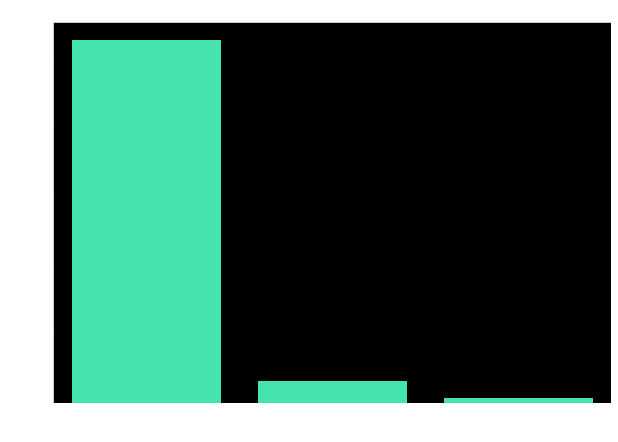

In [26]:
fig = plt.figure(figsize=[10,7])
g = sns.countplot(challenges['programming_language'],
                 color=sns.xkcd_rgb['greenish cyan'])
g.set_title('Distribution of challenges w.r.p.t. programming language')
plt.show()

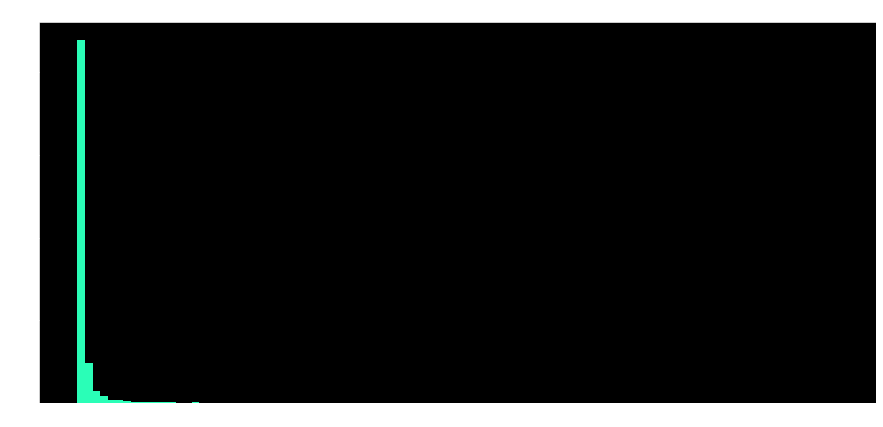

In [27]:
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.hist(challenges['total_submissions'],
        color=sns.xkcd_rgb['greenish cyan'],
        bins=100)

ax.set_title('Distribution of total number of submissions')
plt.show()

In [28]:
# max number of submissions for a challenge
max(challenges['total_submissions'])

43409.0

In [29]:
# number of authors
len(challenges['author_ID'].unique())

3485

In [30]:
# number of author organisation
len(challenges['author_org_ID'].unique())

1718

In [31]:
# author gender
challenges['author_gender'].value_counts()

M    4834
F     675
Name: author_gender, dtype: int64

In [32]:
challenges['publish_date2'] = pd.to_datetime(challenges['publish_date'])
challenges['year'] = challenges['publish_date2'].dt.year
challenges['year'].value_counts()

2008    1577
2007    1289
2009     888
2006     695
2005     462
2004     245
2003     155
2002      92
2010      81
1999      73
2001      46
2000       3
Name: year, dtype: int64

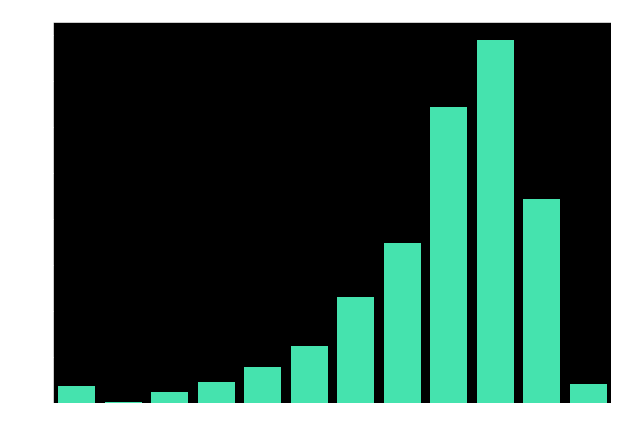

In [33]:
fig = plt.figure(figsize=[10,7])
g = sns.countplot(challenges['year'],
                 color=sns.xkcd_rgb['greenish cyan'])
g.set_title('Distribution of # of challenges per year')
plt.show()

## Data Preparation

### mapping of X and Y

In [34]:
challenges['programming_language'] = challenges['programming_language'].map({1:'lang1',
                                                                             2:'lang2',
                                                                             3:'lang3'})

In [35]:
challenges['total_submissions'] = challenges['total_submissions'].fillna(challenges['total_submissions'].mean())

In [36]:
challenges_final = pd.concat([challenges['challenge_ID'],
                              pd.get_dummies(challenges['programming_language']),
                              pd.get_dummies(challenges['year']),
                              challenges['total_submissions']], axis=1)

In [37]:
challenges_final.head()

,challenge_ID,lang1,lang2,lang3,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,total_submissions
0,CI23478,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,37.0
1,CI23479,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,48.0
2,CI23480,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,15.0
3,CI23481,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,236.0
4,CI23482,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,137.0


In [38]:
Ymap = pd.concat([challenges['challenge_ID'],
                 pd.get_dummies(challenges['challenge_ID'])], axis=1)

In [39]:
Xmap = pd.merge(Ymap,
                challenges_final,
                on='challenge_ID',
                how='inner')

In [40]:
Xmap.head()

,challenge_ID,CI23478,CI23479,CI23480,CI23481,CI23482,CI23483,CI23484,CI23485,CI23486,CI23487,CI23488,CI23489,CI23490,CI23491,CI23492,CI23493,CI23494,CI23495,CI23496,CI23497,CI23498,CI23499,CI23500,CI23501,CI23502,CI23503,CI23504,CI23505,CI23506,CI23507,CI23508,CI23509,CI23510,CI23511,CI23512,CI23513,CI23514,CI23515,CI23516,...,CI29060,CI29061,CI29062,CI29063,CI29064,CI29065,CI29066,CI29067,CI29068,CI29069,CI29070,CI29071,CI29072,CI29073,CI29074,CI29075,CI29076,CI29077,CI29078,CI29079,CI29080,CI29081,CI29082,CI29083,lang1,lang2,lang3,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,total_submissions
0,CI23478,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,37.0
1,CI23479,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,48.0
2,CI23480,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,15.0
3,CI23481,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,236.0
4,CI23482,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,137.0


In [41]:
Ymap.set_index('challenge_ID', inplace=True)
Xmap.set_index('challenge_ID', inplace=True)

In [42]:
Ymap.head()

,CI23478,CI23479,CI23480,CI23481,CI23482,CI23483,CI23484,CI23485,CI23486,CI23487,CI23488,CI23489,CI23490,CI23491,CI23492,CI23493,CI23494,CI23495,CI23496,CI23497,CI23498,CI23499,CI23500,CI23501,CI23502,CI23503,CI23504,CI23505,CI23506,CI23507,CI23508,CI23509,CI23510,CI23511,CI23512,CI23513,CI23514,CI23515,CI23516,CI23517,...,CI29044,CI29045,CI29046,CI29047,CI29048,CI29049,CI29050,CI29051,CI29052,CI29053,CI29054,CI29055,CI29056,CI29057,CI29058,CI29059,CI29060,CI29061,CI29062,CI29063,CI29064,CI29065,CI29066,CI29067,CI29068,CI29069,CI29070,CI29071,CI29072,CI29073,CI29074,CI29075,CI29076,CI29077,CI29078,CI29079,CI29080,CI29081,CI29082,CI29083
challenge_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CI23478,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CI23479,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CI23480,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CI23481,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CI23482,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
chall2num = dict()
num2chall = dict()
for num, col in enumerate(Ymap.columns):
    chall2num[col] = num
    num2chall[num] = col

### indices of X and Y

In [44]:
# map of train data
train.set_index('user_sequence', inplace=True)
test.set_index('user_sequence', inplace=True)

In [45]:
train.head()

,user_id,challenge_sequence,challenge
user_sequence,,,
4576_1,4576,1,CI23714
4576_2,4576,2,CI23855
4576_3,4576,3,CI24917
4576_4,4576,4,CI23663
4576_5,4576,5,CI23933


In [46]:
def create_train_samples(train):
    uid_train = train['user_id'].unique()
    Xtrain = list()
    Y = list()

    for uid in tqdm(uid_train):
        lst1 = list(); lst2 = list(); lst3= list()
        for idx in range(1,11):
            lst1.append(chall2num[train['challenge'].loc[str(uid)+'_'+str(idx)]])
            lst2.append(chall2num[train['challenge'].loc[str(uid)+'_'+str(idx+1)]])
            lst3.append(chall2num[train['challenge'].loc[str(uid)+'_'+str(idx+2)]])
        Xtrain.append(lst1)
        Y.append(Ymap.loc[train['challenge'].loc[str(uid)+'_'+str(11)]])
        Xtrain.append(lst2)
        Y.append(Ymap.loc[train['challenge'].loc[str(uid)+'_'+str(12)]])
        Xtrain.append(lst3)
        Y.append(Ymap.loc[train['challenge'].loc[str(uid)+'_'+str(13)]])
        
    return Xtrain, Y

In [48]:
X, Y = create_train_samples(train)

100%|██████████| 69532/69532 [02:25<00:00, 479.08it/s]


In [49]:
X, Y = np.array(X), np.array(Y)

## Create Model

In [58]:
# create sequential model instance
model = Sequential()
# embedding layer
model.add(Embedding(5606, 512, input_length=10))
# add lstm layers
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
# 2nd layer
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
# # 3rd layer
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.2))
# # 4th layer
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.2))
# add dense time distributed dense layer
model.add(Flatten())
model.add(Dense(5606, activation='softmax'))
# model summary
model.summary()
# compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 512)           2870272   
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5606)             

In [59]:
model.fit(X, Y, epochs=60, batch_size=1024, verbose=1)

Epoch 1/60
208596/208596 [==============================] - 65s 310us/step - loss: 6.0009 - accuracy: 0.0265
Epoch 2/60
208596/208596 [==============================] - 64s 309us/step - loss: 4.9300 - accuracy: 0.0581
Epoch 3/60
208596/208596 [==============================] - 64s 309us/step - loss: 4.4880 - accuracy: 0.0920
Epoch 4/60
208596/208596 [==============================] - 64s 309us/step - loss: 4.0774 - accuracy: 0.1422
Epoch 5/60
208596/208596 [==============================] - 64s 309us/step - loss: 3.6300 - accuracy: 0.2097
Epoch 6/60
208596/208596 [==============================] - 64s 309us/step - loss: 3.1555 - accuracy: 0.2880
Epoch 7/60
208596/208596 [==============================] - 64s 309us/step - loss: 2.6859 - accuracy: 0.3717
Epoch 8/60
208596/208596 [==============================] - 64s 309us/step - loss: 2.2501 - accuracy: 0.4579
Epoch 9/60
208596/208596 [==============================] - 65s 309us/step - loss: 1.8699 - accuracy: 0.5378
Epoch 10/60
208596/

In [60]:
# create test data set
def create_test_samples(test, start, end, uid_test):
    # uid_test = test['user_id'].unique()
    Xtest = list()

    for uid in tqdm(uid_test):
        lst1 = list()
        for idx in range(start,end):
            lst1.append(chall2num[test['challenge'].loc[str(uid)+'_'+str(idx)]])
        Xtest.append(lst1)
        
    return Xtest

# predict next challenge
def predict_next_challenge(Xtest, model, num2chall):
    pred = model.predict(Xtest)
    pred = np.argmax(pred, axis=1)
    pred = [num2chall[item] for item in pred]
    return pred

# create predicted data frame
def predicted_df(uid_test, pred, end):
    user_sequence = [str(uid)+'_'+str(end) for uid in uid_test]
    challenge_sequence = [end]*uid_test.shape[0]
    df = pd.DataFrame({'user_id': uid_test,
                       'challenge_sequence': challenge_sequence,
                       'challenge': pred}, index=user_sequence)
    return df

# predict test data
def predict_3_challenges(test, model, num2chall):
    uid_test = test['user_id'].unique()
    # dummy_data = cp.deepcopy(test)

    # loop over test data to predict next 3 challenges
    for i in range(1,4):
      start = i
      end = i+10
      Xtest = create_test_samples(test, start, end, uid_test)
      Xtest = np.array(Xtest)
      pred = predict_next_challenge(Xtest, model, num2chall)
      df = predicted_df(uid_test, pred, end)
      test = pd.concat([test, df])

    return test

In [61]:
test_final = predict_3_challenges(test,model,num2chall)

100%|██████████| 39732/39732 [00:15<00:00, 2628.95it/s]


## Submissions

In [62]:
test_final = test_final[test_final['challenge_sequence'] > 10]

In [63]:
test_final.head()

,user_id,challenge_sequence,challenge
4577_11,4577,11,CI24530
4578_11,4578,11,CI24530
4579_11,4579,11,CI26959
4583_11,4583,11,CI24917
4584_11,4584,11,CI24530


In [64]:
submission = pd.DataFrame({'user_sequence': test_final.index,
                           'challenge': test_final['challenge']})

In [65]:
submission.to_csv(test_dir+'/Submission5.csv', index=False)